## EDA

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

- N : Non-ecotic beats (normal beat) 
- S : Supraventricular ectopic beats 
- V : Ventricular ectopic beats 
- F : Fusion Beats 
- Q : Unknown Beats 

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [60]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
train_df=pd.read_csv('datasets/mitbih_train.csv',header=None)
test_df=pd.read_csv('datasets/mitbih_test.csv',header=None)

In [3]:
train_df.shape

(87554, 188)

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_df[187] = train_df[187].astype(int)
train_df[187].value_counts()

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64

Text(0.5, 1.0, 'Target Distribution')

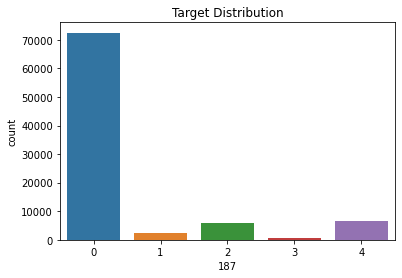

In [6]:
sns.countplot(x=train_df[187])
plt.title('Target Distribution')

We can see that the dataset is very unbalanced

In [7]:
df_1 = train_df[train_df[187]==1]
df_2 = train_df[train_df[187]==2]
df_3 = train_df[train_df[187]==3]
df_4 = train_df[train_df[187]==4]
df_0 = (train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample = resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample = resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample = resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample = resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

In [8]:
# train_df[187] = train_df[187].astype(int)
train_df[187].value_counts()

0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64

In [21]:
sample_0 = train_df[train_df[187]==0].sample(1, random_state=7).iloc[0,:186]
sample_1 = train_df[train_df[187]==1].sample(1, random_state=7).iloc[0,:186]
sample_2 = train_df[train_df[187]==2].sample(1, random_state=7).iloc[0,:186]
sample_3 = train_df[train_df[187]==3].sample(1, random_state=7).iloc[0,:186]
sample_4 = train_df[train_df[187]==4].sample(1, random_state=7).iloc[0,:186]

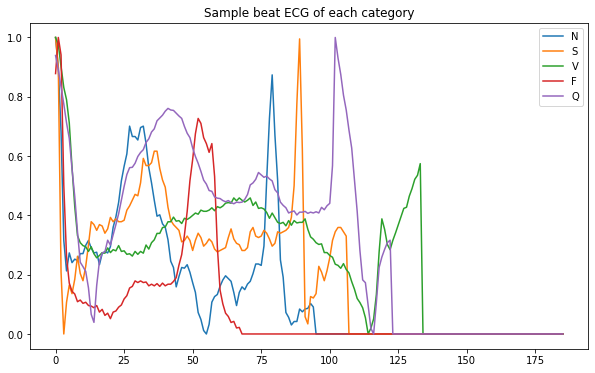

In [37]:
plt.figure(figsize=(10,6))
plt.plot(sample_0, label='N')
plt.plot(sample_1, label='S')
plt.plot(sample_2, label='V')
plt.plot(sample_3, label='F')
plt.plot(sample_4, label='Q')
plt.title('Sample beat ECG of each category')
plt.legend()
plt.show()


In [55]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [57]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [61]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [63]:
model,history=network(X_train, y_train, X_test, y_test)

Epoch 1/40
3125/3125 [==============================] - 73s 23ms/step - loss: 0.2988 - accuracy: 0.8919 - val_loss: 0.2371 - val_accuracy: 0.9129
Epoch 2/40
3125/3125 [==============================] - 70s 22ms/step - loss: 0.0782 - accuracy: 0.9730 - val_loss: 0.1292 - val_accuracy: 0.9604
Epoch 3/40
3125/3125 [==============================] - 73s 23ms/step - loss: 0.0501 - accuracy: 0.9833 - val_loss: 0.1390 - val_accuracy: 0.9617
Epoch 4/40
3125/3125 [==============================] - 62s 20ms/step - loss: 0.0366 - accuracy: 0.9879 - val_loss: 0.1155 - val_accuracy: 0.9699
Epoch 5/40
3125/3125 [==============================] - 74s 24ms/step - loss: 0.0282 - accuracy: 0.9910 - val_loss: 0.1470 - val_accuracy: 0.9619
Epoch 6/40
3125/3125 [==============================] - 65s 21ms/step - loss: 0.0245 - accuracy: 0.9921 - val_loss: 0.1168 - val_accuracy: 0.9725
Epoch 7/40
3125/3125 [==============================] - 63s 20ms/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 0.1412 -